In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2
import tensorflow as tf
from tqdm import tqdm
import imgaug.augmenters as iaa
import time
from imgaug import parameters as iap

seed = None
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
sartorius_df = pd.read_csv('../sartorius-cell-instance-segmentation/train.csv')

HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

In [3]:
def make_mask(image_id, SHAPE=(520, 704)):
    rows = sartorius_df.loc[sartorius_df['id'] == image_id]
    
    # Image shape
    mask = np.full(shape=[len(rows), np.prod(SHAPE)], fill_value=0, dtype=np.uint8)
    
    for idx, (_, row) in enumerate(rows.iterrows()):
        s = row['annotation'].split()
        starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[idx, lo:hi] = True
        
    mask = mask.reshape([len(rows), *SHAPE])
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

# Run Length Encode an instance
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    #img = unpad_image(img)
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [6]:
get_image_path = lambda image_id: '{}.{}'.format(os.path.join('../sartorius-cell-instance-segmentation/train/', image_id), 'png')

def mosaic(image_ids, SHAPE, seed):
    # Split images to stack
    stack_01_ids, stack_02_ids = image_ids[:2], image_ids[2:]
    
    # Load image
    stack_01_imgs = [io.imread(get_image_path(image_id)) 
                     for image_id in stack_01_ids]
    stack_02_imgs = [io.imread(get_image_path(image_id))
                     for image_id in stack_02_ids]
    
    # Horizontal stack images
    hstack_01 = np.hstack(stack_01_imgs)
    hstack_02 = np.hstack(stack_02_imgs)
    
    # Vertical stack
    mosaic_image = np.vstack((hstack_01, hstack_02))
    
    # Mosaic mask
    stack_01_masks = [make_mask(image_id) for image_id in stack_01_ids]
    stack_02_masks = [make_mask(image_id) for image_id in stack_02_ids]
        
    #print(stack_01_masks[0].shape)
    #print(stack_01_masks[1].shape)
    #print(stack_02_masks[0].shape)
    #print(stack_02_masks[1].shape)
        
    mosaic_masks = mosaic_gt(image_ids)
    
    mosaic_image, mosaic_masks = random_crop(mosaic_image, mosaic_masks, SHAPE, seed)
    
    # After random cropping, the mosaic_masks may has all zero values
    # in random channels, we must remove those channels which contain 
    # all zero values aka. do not contain instances
    #mosaic_masks = remove_zero_channel_from_mask(mosaic_masks)
        
    return mosaic_image, mosaic_masks

def mosaic_gt(image_ids):
    # Split images to stack
    stack_01_ids, stack_02_ids = image_ids[:2], image_ids[2:]
    
    # Load mask
    stack_01_masks = [make_mask(image_id) for image_id in stack_01_ids]
    stack_02_masks = [make_mask(image_id) for image_id in stack_02_ids]
    
    # First 2 images locate at upper left and right of the mask,
    # last 2 images locate at lower left and right of the mask corresponding
    masks_01, masks_02 = stack_01_masks
    masks_03, masks_04 = stack_02_masks
    
    # Compute total depth aka. total number of instances from 4 masks
    num_upper_ins = masks_01.shape[-1] + masks_02.shape[-1]
    num_lower_ins = masks_03.shape[-1] + masks_04.shape[-1]
    num_ins = num_upper_ins + num_lower_ins
    
    # After concatenate, height and width of mask increase twice
    mosaic_mask = np.zeros((HEIGHT*2, WIDTH*2, num_ins), dtype=np.uint8)
    
    
    # Upper
    mosaic_mask[:HEIGHT, :WIDTH, :masks_01.shape[-1]] = masks_01
    #print('[0:{}]'.format(masks_01.shape[-1]))
    mosaic_mask[:HEIGHT, WIDTH:, masks_01.shape[-1]:num_upper_ins] = masks_02
    #print('[{}:{}]'.format(masks_01.shape[-1], num_upper_ins))
    
    # Lower
    mosaic_mask[HEIGHT:, :WIDTH, 
                num_upper_ins:(num_ins - masks_04.shape[-1])] = masks_03
    #print('[{}:{}]'.format(num_upper_ins, num_ins-masks_04.shape[-1]))
    mosaic_mask[HEIGHT:, WIDTH:, num_ins-masks_04.shape[-1]:] = masks_04
    #print('[{}:{}]'.format(num_ins-masks_04.shape[-1], mosaic_mask.shape[-1]))
    
    
    return mosaic_mask

def random_crop(image, mask, crop_shape, seed):    
    if len(image.shape) < 3:
        image = np.expand_dims(image, axis=-1)
    num_image_channels = image.shape[-1]
    
    stacked_image = np.concatenate([image, mask.astype(image.dtype)], axis=-1)
    
    aug_seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Crop(percent=0.25, keep_size=False)
    ])
    
    stacked_image = aug_seq.augment_image(stacked_image)
    
    image = stacked_image[..., :num_image_channels]
    mask = stacked_image[..., num_image_channels:]
    
    return image, mask

def remove_zero_channel_from_mask_1(masks):
    """
    Remove zero channel (dont contain instance) from mask
    after crop from mosaic
    """
    
    # Swap depth and height channel from masks, in order to
    # sort the depth nonzero indices while using nonzero() func.
    masks_swap = np.swapaxes(masks, 0, 2)
    d, w, h = masks_swap.nonzero()
    
    d_pad = np.concatenate([[-1], d, [-1]])
    runs = np.where(d_pad[1:] != d_pad[:-1])[0]
    new_d = np.zeros(len(d), dtype=np.uint32)
    
    num_ins = len(runs) - 1
    
    for i, (start, end) in enumerate(zip(runs[:-1], runs[1:])):
           new_d[start: end] = i
        
    new_masks = np.zeros((*masks.shape[:-1], num_ins))
    new_masks[h, w, new_d] = 1
    
    return new_masks

def remove_zero_channel_from_mask_2(masks):
    """
    Remove zero channel (dont contain instance) from mask
    after crop from mosaic
    """
    
    # Swap depth and height channel from masks, in order to
    # sort the depth nonzero indices while using nonzero() func.
    _idx = np.sum(masks, axis=(0, 1)) > 0
    masks = masks[..., _idx]
    return masks
    

# Check func.
def is_crop_mask_and_non_zero_mask_equal(crop_mask, non_zero_mask):
    _, _, d = crop_mask.nonzero()
    d_unique = pd.Series(d).unique()
    d_sort = np.sort(d_unique)
    d_order = np.concatenate([np.where(d_sort == i)[0] for i in d_unique])

    count = 0
    for i in range(len(d_unique)):
        if np.abs(crop_mask[..., d_unique[i]] - non_zero_mask[..., d_order[i]]).sum() > 0:
            print('False')
        else:
            count += 1
        if count == len(d_unique):
            print('True')

In [12]:
#Test funct.
cort_ids = sartorius_df[sartorius_df['cell_type'] == 'cort']['id'].unique()
ids = np.random.choice(cort_ids, 4, replace=False)

"""
# Note: In order to check, this mosaic() func. does not return non_zero_mask, 
# so that please turn of remove_zero_channel() in this mosaic() func.
image, mask = mosaic(ids, (HEIGHT, WIDTH), seed)
non_zero_mask = remove_zero_channel_from_mask_2(mask)
is_crop_mask_and_non_zero_mask_equal(mask, non_zero_mask)
"""

'\n# Note: In order to check, this mosaic() func. does not return non_zero_mask, \n# so that please turn of remove_zero_channel() in this mosaic() func.\nimage, mask = mosaic(ids, (HEIGHT, WIDTH), seed)\nnon_zero_mask = remove_zero_channel_from_mask_2(mask)\nis_crop_mask_and_non_zero_mask_equal(mask, non_zero_mask)\n'

In [13]:
cort_ids = sartorius_df.loc[sartorius_df['cell_type'] == 'cort', 'id'].unique()
shsy5y_ids = sartorius_df.loc[sartorius_df['cell_type'] == 'shsy5y', 'id'].unique()
astro_ids = sartorius_df.loc[sartorius_df['cell_type'] == 'astro', 'id'].unique()

np.random.seed(42)
ids = np.random.choice(astro_ids, 4, replace=False)

In [14]:
image, mask = mosaic(ids, (HEIGHT, WIDTH), seed)

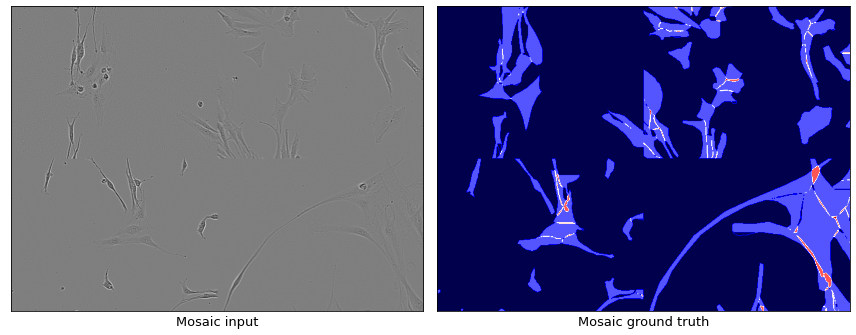

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

axs[0].imshow(image, cmap='gray')
axs[0].set_xlabel('Mosaic input', fontsize=13)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(np.sum(mask, -1), cmap='seismic')
axs[1].set_xlabel('Mosaic ground truth', fontsize=13)
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
plt.subplots(figsize=(10, 10))

merged = cv2.addWeighted(image[..., 0], 0.75, 
                        np.clip(np.sum(mask, -1).astype(image.dtype), 0, 1)*255, 0.25, 0.0,)
plt.imshow(merged, cmap='gray')
plt.axis('off')

In [ ]:
a = np.arange

In [ ]:
def rle2mask(rle, shape):
    array = np.fromiter(rle.split(), dtype=np.uint32)
    array = array.reshape(-1, 2)
    array[:, 0] = array[:, 0] - 1
    
    mask_decompressed = np.concatenate([np.arange(i[0], i[0] + i[1], 
                                                 dtype=np.uint32) for i in array])
    
    mask = np.zeros(SHAPE[0] * SHAPE[1], dtype=np.uint32)
    mask[mask_decompressed] = 1
    mask = mask.reshape(SHAPE)
    
    return mask

def get_box_height_width(rle, shape=SHAPE):
    mask = rle2mask(rle, shape)
    nonzero_coords = np.transpose(np.nonzero(mask))
    box_height = nonzero_coords[:, 0].max() - nonzero_coords[:, 0].min()
    box_width = nonzero_coords[:, 1].max() - nonzero_coords[:, 1].min()
    
    return box_height, box_width

In [ ]:
cort_annots = []
cort_df = sartorius_df[sartorius_df['cell_type'] == 'cort']
cort_ids = cort_df['id'].unique()

start = time.time()

for cort_id in tqdm(cort_ids):
    # Get random 3 images
    mosaic_image_ids = np.random.choice(cort_ids, 3, replace=False)
    
    # Append current image
    mosaic_image_ids = np.append(mosaic_image_ids, cort_id)
    
    mosaic_image, mosaic_mask = mosaic(mosaic_image_ids, SHAPE, seed)
    
    annot = []
    for idx in range(mosaic_mask.shape[-1]):
        annot.append(rle_encode(mosaic_mask[..., idx]))
        
    cort_annots += annot
    
end = time.time()

In [ ]:
process_time = round((end - start) / 60, 2)
print('It took {} minute(s) to applied mosaic (resize) over {} CORT images'.format(process_time, len(cort_ids)))

In [ ]:
astro_annots = []
astro_df = sartorius_df[sartorius_df['cell_type'] == 'astro']
astro_ids = astro_df['id'].unique()

start = time.time()

for astro_id in tqdm(astro_ids):
    # Get random 3 images
    mosaic_image_ids = np.random.choice(astro_ids, 3, replace=False)
    mosaic_image_ids = np.append(mosaic_image_ids, astro_id)
    mosaic_image, mosaic_mask = mosaic(mosaic_image_ids, SHAPE, seed)
    
    annot = []
    for idx in range(mosaic_mask.shape[-1]):
        annot.append(rle_encode(mosaic_mask[..., idx]))
        
    astro_annots += annot
    
end = time.time()

In [ ]:
process_time = round((end - start) / 60, 2)
print('It took {} minute(s) to applied mosaic (resize) over {} ASTRO images'.format(process_time, len(astro_ids)))

In [ ]:
shsy5y_df = sartorius_df[sartorius_df['cell_type'] == 'shsy5y']
cort_df = sartorius_df[sartorius_df['cell_type'] == 'cort']

print('Number of instances of SHSY5Y: ', shsy5y_df.shape[0])
print('Number of instances of CORT: ', len(cort_annots))
print('Number of instances of ASTRO: ', len(astro_annots))

In [ ]:
print('Number of CORT instances of BEFORE AUGMENTING: ', cort_df.shape[0])
print('Number of CORT instances of AFTER AUGMENTING: ', len(cort_annots))

In [ ]:
print('CORT increases {} instances after augmenting'.format(len(cort_annots) - cort_df.shape[0]))

In [ ]:
print('Number of ASTRO instances of BEFORE AUGMENTING: ', astro_df.shape[0])
print('Number of ASTRO instances of after AUGMENTING: ', len(astro_annots))

In [ ]:
print('ASTRO increases {} instances after augmenting'.format(len(astro_annots) - astro_df.shape[0]))

In [ ]:
shsy5y_df.shape[0] / len(cort_annots)

In [ ]:
shsy5y_df.shape[0] / len(astro_annots)

Cort instance size


In [ ]:
cort_height_width = [get_box_height_width(rle) for rle in cort_annots]
cort_height_width = pd.DataFrame(cort_height_width)
cort_height_width.describe()

Astro instance size

In [ ]:
astro_height_width = [get_box_height_width(rle) for rle in astro_annots]
astro_height_width = pd.DataFrame(astro_height_width)
astro_height_width.describe()